In [3]:
import csv

def count_csv_rows(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        return sum(1 for row in csv.reader(f))

# 使用示例
filename = 'E:\Code\PythonProgamme\DS_learning\Criteo-Uplift\data\criteo-uplift.csv'
total_rows = count_csv_rows(filename)
print(f"总行数（包括标题行）: {total_rows}")

总行数（包括标题行）: 13979593


In [7]:
import pandas as pd

# 1. 先读取全部数据（或足够大的样本）
df_full = pd.read_csv("../data/criteo-uplift.csv")

# 2. 确保 treatment 分布均衡（T:C ≈ 1:1）
print("Original treatment distribution:")
print(df_full['treatment'].value_counts(normalize=True))

# 3. 随机抽样 100,000 行，且保证 T 和 C 各 50,000
n_per_group = 50_000
df_t = df_full[df_full['treatment'] == 1].sample(n=n_per_group, random_state=42)
df_c = df_full[df_full['treatment'] == 0].sample(n=n_per_group, random_state=42)

# 合并
df_sample = pd.concat([df_t, df_c], ignore_index=True)

# 打乱顺序
df_sample = df_sample.sample(frac=1, random_state=42).reset_index(drop=True)

# 保存为新文件
df_sample.to_csv("../data/criteo-uplift-sample.csv", index=False)
print(f"Balanced sample saved! Shape: {df_sample.shape}")
print("Treatment distribution in sample:")
print(df_sample['treatment'].value_counts(normalize=True))

Original treatment distribution:
treatment
1    0.85
0    0.15
Name: proportion, dtype: float64
Balanced sample saved! Shape: (100000, 16)
Treatment distribution in sample:
treatment
0    0.5
1    0.5
Name: proportion, dtype: float64


加载数据（先用小样本快速验证）

In [8]:
import pandas as pd

# 只读前 100,000 行用于 EDA（足够看分布）
df_sample = pd.read_csv("../data/criteo-uplift-sample.csv")

# 查看前几行
print(df_sample.head())

          f0         f1        f2        f3         f4        f5        f6  \
0  12.616365  10.059654  8.342151  4.679882  10.280525  4.115453  0.294443   
1  24.286434  10.059654  8.214383  4.679882  10.280525  4.115453 -5.987667   
2  26.391621  10.059654  8.214383  4.679882  10.280525  4.115453 -1.288207   
3  14.206224  10.059654  8.935635  2.293959  10.280525  4.115453 -4.595460   
4  23.087444  10.059654  8.969849  4.679882  10.280525  4.115453 -2.411115   

         f7        f8         f9       f10       f11  treatment  conversion  \
0  4.833815  3.812625  32.395545  5.300375 -0.168679          0           0   
1  4.833815  3.971858  13.190056  5.300375 -0.168679          0           0   
2  4.833815  3.971858  13.190056  5.300375 -0.168679          1           0   
3  4.833815  3.955396  13.190056  5.300375 -0.168679          0           0   
4  4.833815  3.880455  13.190056  5.300375 -0.168679          0           0   

   visit  exposure  
0      0         0  
1      0      

基础数据检查

In [9]:
# 1. 数据形状
print("Shape:", df_sample.shape)

# 2. 缺失值？
print("Missing values:\n", df_sample.isnull().sum())

# 3. treatment 和 conversion 的分布
print("\nTreatment distribution:")
print(df_sample['treatment'].value_counts(normalize=True))

print("\nConversion distribution (overall):")
print(df_sample['conversion'].value_counts(normalize=True))

# 4. 转化率在 T/C 组的差异（这是真实 uplift！）
conv_t = df_sample[df_sample['treatment'] == 1]['conversion'].mean()
conv_c = df_sample[df_sample['treatment'] == 0]['conversion'].mean()
real_uplift = conv_t - conv_c

print(f"\nConversion rate in Treatment group: {conv_t:.4f}")
print(f"Conversion rate in Control group:   {conv_c:.4f}")
print(f"Observed average uplift:            {real_uplift:.4f}")

Shape: (100000, 16)
Missing values:
 f0            0
f1            0
f2            0
f3            0
f4            0
f5            0
f6            0
f7            0
f8            0
f9            0
f10           0
f11           0
treatment     0
conversion    0
visit         0
exposure      0
dtype: int64

Treatment distribution:
treatment
0    0.5
1    0.5
Name: proportion, dtype: float64

Conversion distribution (overall):
conversion
0    0.9976
1    0.0024
Name: proportion, dtype: float64

Conversion rate in Treatment group: 0.0027
Conversion rate in Control group:   0.0021
Observed average uplift:            0.0006


验证随机性

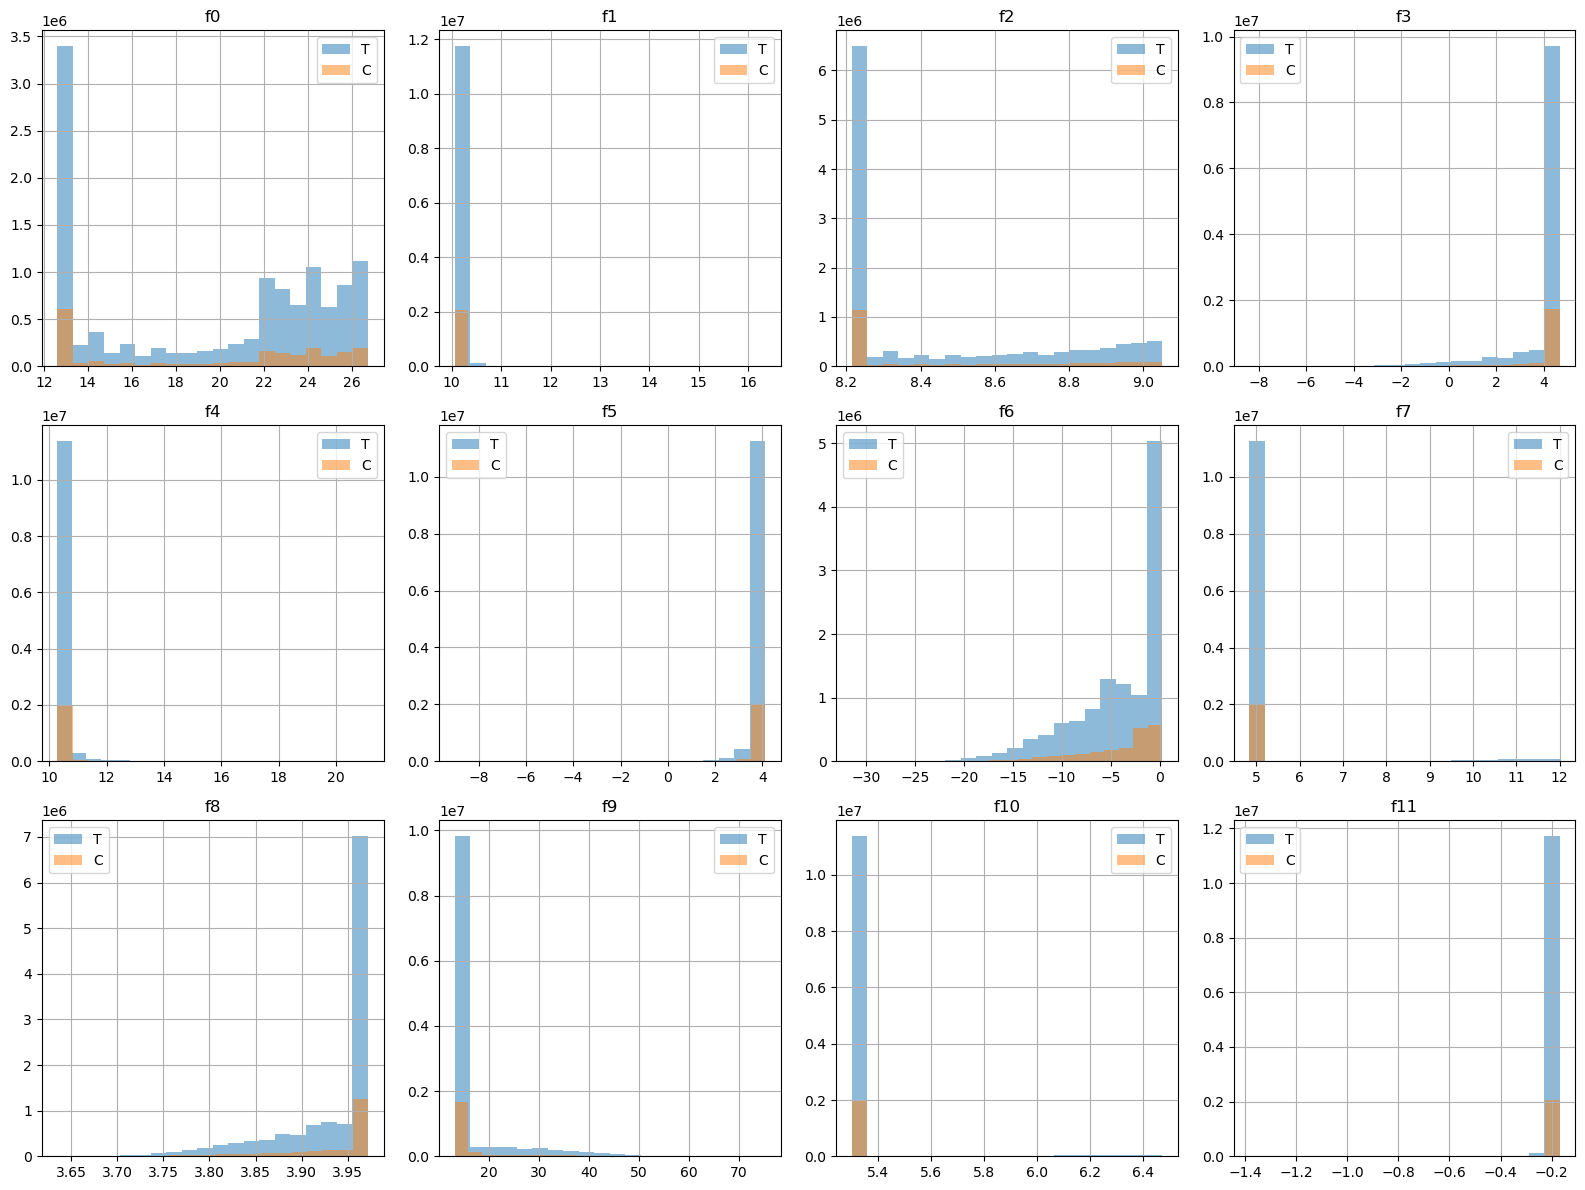

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
df=df_full
features = [f'f{i}' for i in range(0, 12)]

# 选几个代表性特征，画 T/C 组分布对比
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for i, feat in enumerate(features):
    ax = axes[i]
    # 如果是类别型（unique < 50），用 countplot；否则用 hist
    if df[feat].nunique() < 50:
        sns.countplot(data=df, x=feat, hue='treatment', ax=ax)
    else:
        df[df['treatment']==1][feat].hist(alpha=0.5, label='T', bins=20, ax=ax)
        df[df['treatment']==0][feat].hist(alpha=0.5, label='C', bins=20, ax=ax)
        ax.legend()
    ax.set_title(feat)

plt.tight_layout()
plt.savefig("../figures/feature_balance.png", dpi=150)
plt.show()

所有特征在 treatment/control 组间无显著差异，满足 ignorability 假设。

特征类型与分布分析

In [13]:
# 判断每个 feature 是数值型还是类别型
for feat in features:
    n_unique = df[feat].nunique()
    dtype = df[feat].dtype
    print(f"{feat}: {n_unique} unique values, dtype={dtype}")
    
    # 如果 unique 值少，打印 top 5
    if n_unique <= 10:
        print(df[feat].value_counts().head())
        print("---")

f0: 2181959 unique values, dtype=float64
f1: 60 unique values, dtype=float64
f2: 2051900 unique values, dtype=float64
f3: 552 unique values, dtype=float64
f4: 260 unique values, dtype=float64
f5: 132 unique values, dtype=float64
f6: 1645 unique values, dtype=float64
f7: 622143 unique values, dtype=float64
f8: 3743 unique values, dtype=float64
f9: 1594 unique values, dtype=float64
f10: 517372 unique values, dtype=float64
f11: 136 unique values, dtype=float64


In [15]:
#查看 feature 不同取值下的转化率（分 T/C）
features = [f'f{i}' for i in range(0,12)]
for feat in features:
    print(feat,"=================================")
    if df[feat].nunique() <= 60:  # 只对低基数特征做
        conv_by_feat = df.groupby([feat, 'treatment'])['conversion'].mean().unstack()
        conv_by_feat['uplift'] = conv_by_feat[1] - conv_by_feat[0]
        print(conv_by_feat.sort_values('uplift', ascending=False).head(10))
    print(feat,"=================================finish")

f0 =================================
f0 =================================finish
f1 =================================
treatment         0         1    uplift
f1                                     
13.793413  0.000000  0.346154  0.346154
14.094135  0.000000  0.333333  0.333333
14.390953  0.000000  0.250000  0.250000
13.654339  0.000000  0.225806  0.225806
13.920883  0.000000  0.200000  0.200000
13.331298  0.000000  0.179487  0.179487
13.579750  0.142857  0.291667  0.148810
13.139954  0.117647  0.185714  0.068067
12.359025  0.051724  0.112544  0.060820
12.798822  0.066667  0.126623  0.059957
f1 =================================finish
f2 =================================
f2 =================================finish
f3 =================================
f3 =================================finish
f4 =================================
f4 =================================finish
f5 =================================
f5 =================================finish
f6 =================================
f6 

## 🔍 EDA 关键结论

1. **实验设计有效**：Treatment/Control 组在所有特征上分布一致，满足随机化假设。
2. **低转化场景**：整体转化率仅 0.24%，符合在线广告典型场景。
3. **存在真实 uplift**：全局平均 uplift = +0.0006，表明营销干预有效但微弱。